# Lab 3: Clustering

The goal of this lab session is to code a clustering algorithm, apply it to data and compare the performance with other techniques.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** (groups of 2) by email to *violeta.roizman@l2s.centralesupelec.fr* by October 17, 2018. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import os
import sklearn.cluster as cluster # all clustering techniques but hdbscan
%matplotlib inline
sns.set_context("paper")
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 50, 'linewidths':0}

We will have two toy datasets to try the different methods:

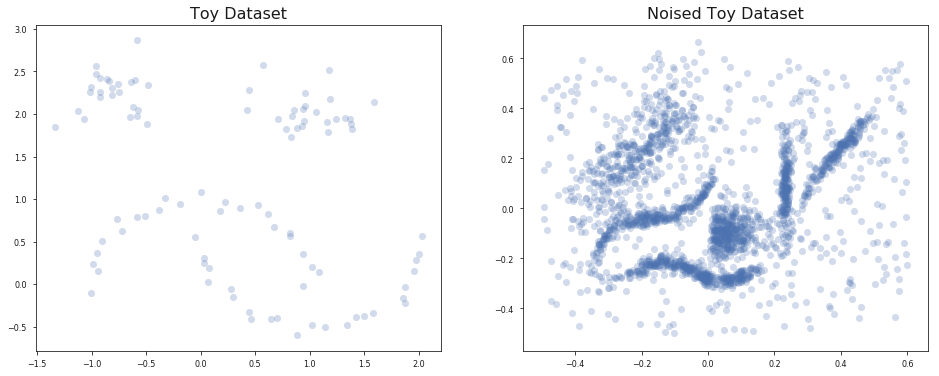

In [6]:
os.chdir("/Users/chalvidalm/Documents/3A OMA/OMA fonda/Machine Learning/Cours 4/data")
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)

plt.show();

There are a lot of clustering algorithms to choose from `sklearn` library. So what clustering algorithms should you be using? It depends.

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

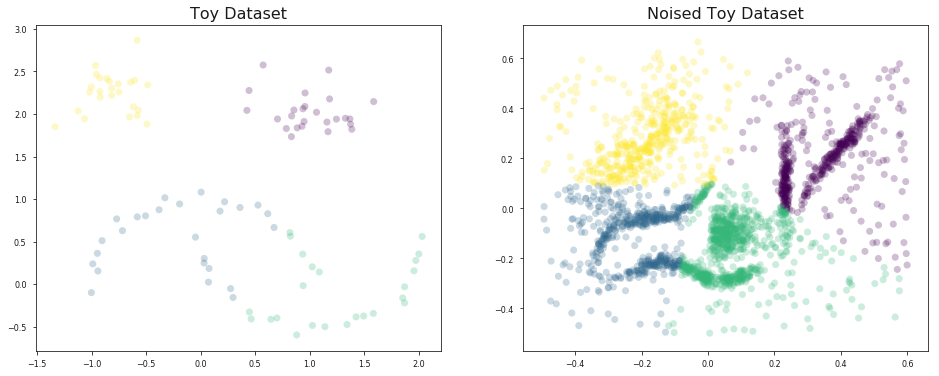

In [7]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

## Aglomerative Single Linkage clustering

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

Apply the method to our toy datasets

In [30]:
class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        ########## declaration of useful variables #########
        
        from scipy.spatial import distance
        cluster=[[i] for i in range(2*X.shape[0]-1)]
        n_obs=X.shape[0]
        
        
        ########## creating distance matrix ###########
        
        if self.metric_ == "precomputed":
            self.distance_mat=X
        elif self.metric_ == 'euclidean':
            
            DC=np.zeros((n_obs,n_obs))
            
            for i in range(n_obs-1):
                for j in range(i+1,n_obs):
                    DC[i,j]=distance.euclidean(X[i],X[j]) 
   
            self.distance_mat=DC + DC.T
        else:
            
            print("Please specify a metric to compute distances between points")
        
        ########## Clustering ##########
         
        # 1 - Remove lower triangular distances from matrice
        
        M = self.distance_mat
        M =  M + np.tril(np.ones((n_obs,n_obs))*np.inf) 
        
        # 2 - Iteration: 
            # Find minimum of the distance matrix  
            # Update distance matrix by removing cluster distance and adding new cluster distances
            # Merging clusters together and updating linkage_mat
            
        Z=np.empty((n_obs-1,4))
        
        for k in range(n_obs-1):
            
            ################ Find minimum of the distance matrix #############
            
            C1,C2 = np.unravel_index(np.argmin(M, axis=None), M.shape)
            nmin=M[C1,C2]
            
            ############# Compute number of points in the cluster ###########
            
            Cluster_dist=np.minimum(M[C1],M[C2])
            
            ############### Update distance matrix ################
            
            M=np.concatenate((M,np.expand_dims(Cluster_dist,1)), axis=1)
            Cluster_dist=np.concatenate((Cluster_dist,[np.inf]))
            bottom=np.expand_dims(Cluster_dist,1).T
            M=np.concatenate((M,bottom),axis=0)
            
            Inf=np.ones(M.shape[1])*np.inf
            M[C1]=Inf
            M[C2]=Inf
            M[:,C1]=Inf
            M[:,C2]=Inf
            
            N_clus=np.unique(np.concatenate((cluster[C1], cluster[C2]), axis=0))
            cluster[C1]=N_clus
            cluster[C1]=N_clus
            cluster[k+n_obs]=N_clus

            ########### updating linkage_mat ###########
            
            Z[k]=[np.min((C1,C2)),np.max((C1,C2)),nmin,len(N_clus)] 
      
        ########## Store linkage Mat ########
    
        self.linkage_matrix_=Z

        self.cluster = cluster
        
    def plot_dendrogram(self):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''
        if self.linkage_matrix_ is None:
            print("please fit data before plotting")
        else:
            scipy.cluster.hierarchy.dendrogram(self.linkage_matrix_)
            plt.show()

#### Test on toy dataset 

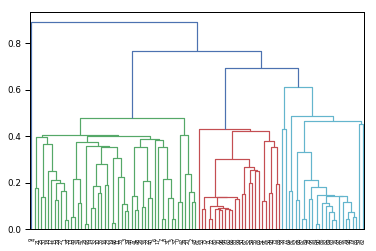

In [31]:
algo=my_SingleLinkageAglomerativeClustering(metric='euclidean')
algo.fit(test_data_0)
algo.plot_dendrogram()

Try the different linkage methods implemented in `sklearn`  and comment

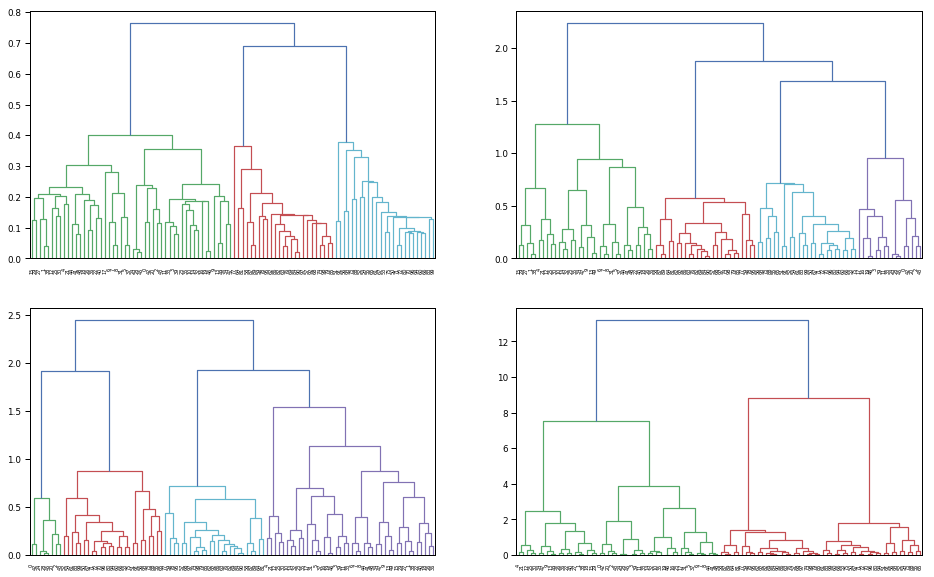

In [32]:
from scipy.cluster.hierarchy import dendrogram
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
plt.subplot(221)
dendrogram(scipy.cluster.hierarchy.linkage(test_data_0, method='single'))
plt.subplot(222)
dendrogram(scipy.cluster.hierarchy.linkage(test_data_0, method='average'))
plt.subplot(223)
dendrogram(scipy.cluster.hierarchy.linkage(test_data_0, method='weighted'))
plt.subplot(224)
dendrogram(scipy.cluster.hierarchy.linkage(test_data_0, method='ward'))
plt.show()

#### Commentary

Each distance leads to a **different segmentation** on our dataset as well as a **different number of clusters**. we see that the ward distance is widening clusters from one another (due to the distance taking in consideration the number of points in the cluster) 

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

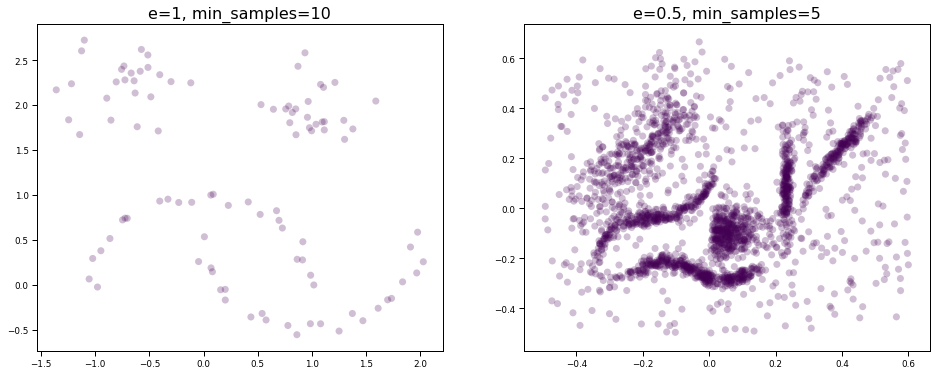

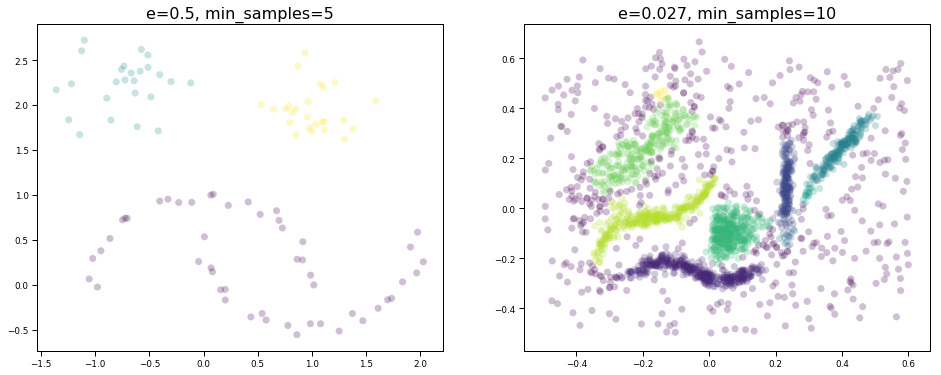

In [33]:
dbscan_0_core, dbscan_0_labels = cluster.dbscan(test_data_0,eps=1, min_samples=10)
dbscan_1_core, dbscan_1_labels = cluster.dbscan(test_data_1,eps=0.5, min_samples=5)
dbscan_2_core, dbscan_2_labels = cluster.dbscan(test_data_0,eps=0.5, min_samples=5)
dbscan_3_core, dbscan_3_labels = cluster.dbscan(test_data_1,eps=0.027, min_samples=10)


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=dbscan_0_labels , **plot_kwds)
ax[0].set_title('e=1, min_samples=10', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=dbscan_1_labels , **plot_kwds)
ax[1].set_title('e=0.5, min_samples=5', size=16)


plt.show();

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=dbscan_2_labels , **plot_kwds)
ax[0].set_title('e=0.5, min_samples=5', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=dbscan_3_labels , **plot_kwds)
ax[1].set_title('e=0.027, min_samples=10', size=16, )


plt.show();



##### Commentary

The plots presented above show that fine-tuning dbscan is a hard task as parameters are intrinsically dependant to the geometry of the data. There is no a priori assumption possible in order to tune this algorithm. However we must bear in mind that:

 - If we specify a **epsilon too small**, we end up with all data points labelled as noise as in figure (1,1) since all points fail to meet the neighbouring recquirement. On the other end if epsilon is too big, noisy data will be merge into a big cluster as in figure (1,2)
 

 - Regarding the **min_sample parameter**, there is a similar trade-off between clustering too much or too little data, depending on many neighbouring points we specify.

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

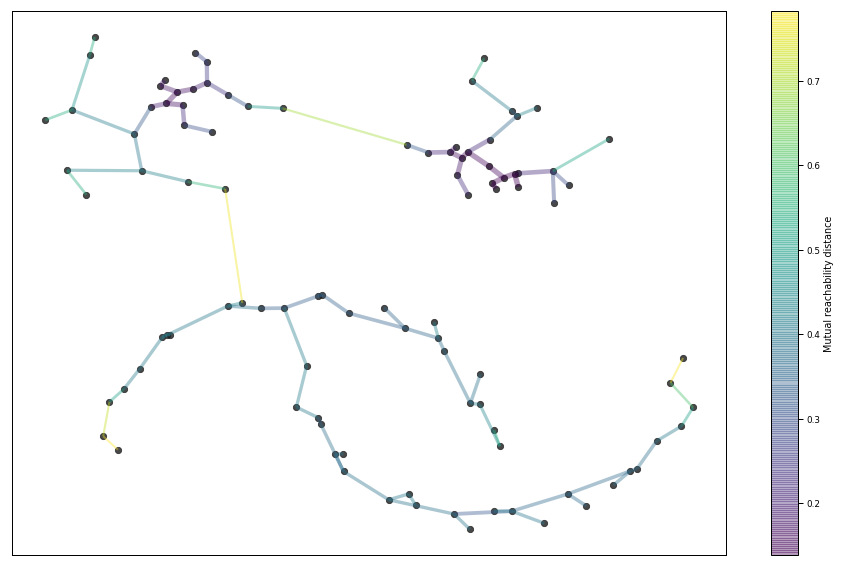

In [73]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data_0)

fig, ax = plt.subplots(1, 1, figsize=(16, 10))

clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.4,
                                      node_size=40,
                                      edge_linewidth=2,vary_line_width=True,axis=ax)


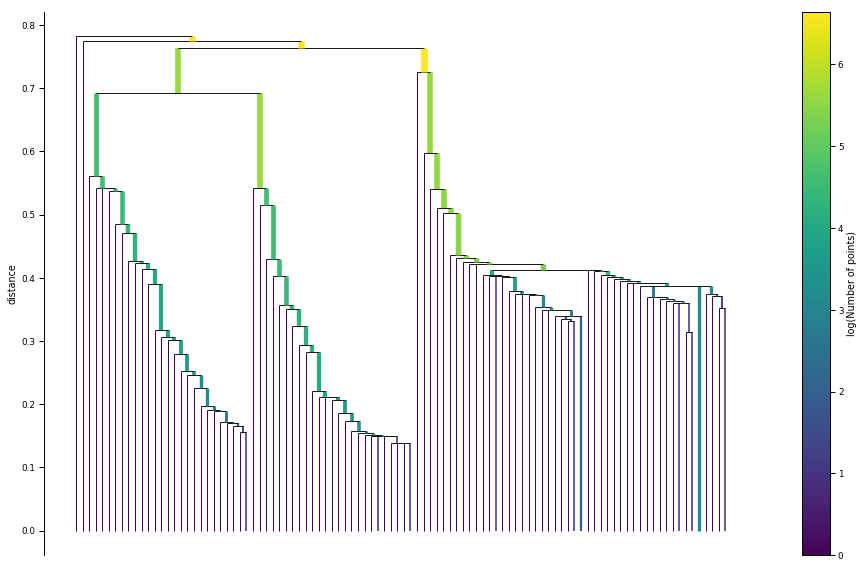

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True,axis=ax)
#clusterer.condensed_tree_.plot()

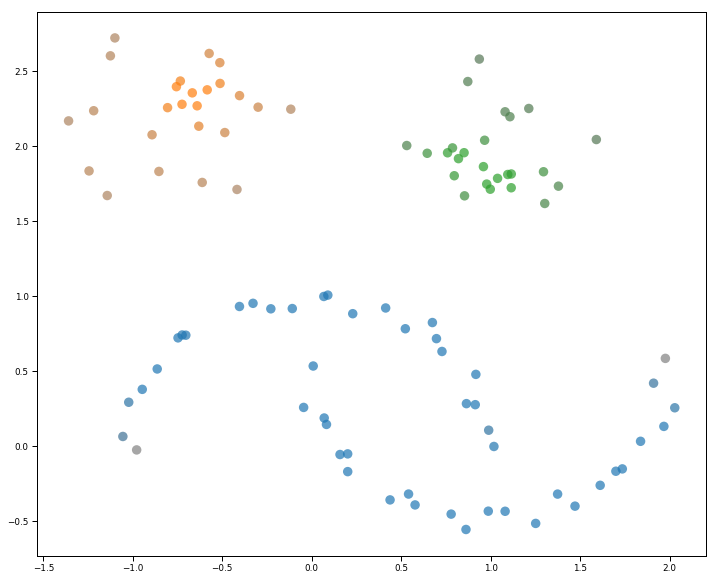

In [76]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.scatter(test_data_0.T[0], test_data_0.T[1], c=cluster_colors, **{'alpha' : 0.7, 's' : 90, 'linewidths':0})

## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


In [2]:
from PIL import Image
Im_1  = Image.open('im_nasa_reduced.jpg')
fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'im_nasa_.jpg'

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

In [78]:
Int=np.array(Im_1)
Intensity=np.array([[np.sum(i)/3 for i in p] for p in Int])
Saturation=np.array([[1 - (np.sum(i)/3)*np.min(p) for i in p] for p in Int])

- Apply the seen algorithms to segment the image, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

#### DBSCAN 

In [79]:
#####DBSCAN ON RGB Values #####

dims=Int.shape
data=Int.reshape(dims[0]*dims[1],3)
dbscan = cluster.DBSCAN(eps=0.5, min_samples=5)
clustered =dbscan.fit_predict(data)
colorisation = clustered.reshape(dims[0],dims[1])

In [80]:
##### DBSCAN on Intensity/saturation #####

dims=Intensity.shape
data_int=Intensity.reshape(dims[0]*dims[1],1)
data_sat=Saturation.reshape(dims[0]*dims[1],1)
data=np.concatenate((data_int,data_sat),axis=1)

dbscan = cluster.DBSCAN(eps=0.5, min_samples=5)
clustered = dbscan.fit_predict(data)
Intens_sat = clustered.reshape(dims[0],dims[1])

Text(0.5, 1.0, 'DBSCAN on Intensity/saturation, e=0.5, min_samples=5')

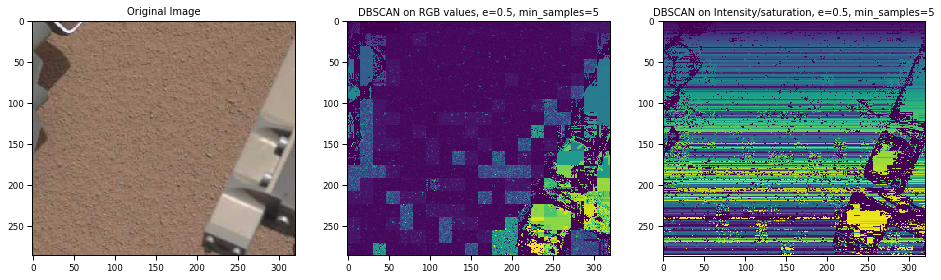

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

ax[0].imshow(Int)
ax[0].set_title('Original Image', size=10)
ax[1].imshow(colorisation)
ax[1].set_title('DBSCAN on RGB values, e=0.5, min_samples=5', size=10)
ax[2].imshow(Intens_sat)
ax[2].set_title('DBSCAN on Intensity/saturation, e=0.5, min_samples=5', size=10)

#### K-Means

Text(0.5, 1.0, 'K_means on RGB values, k=3')

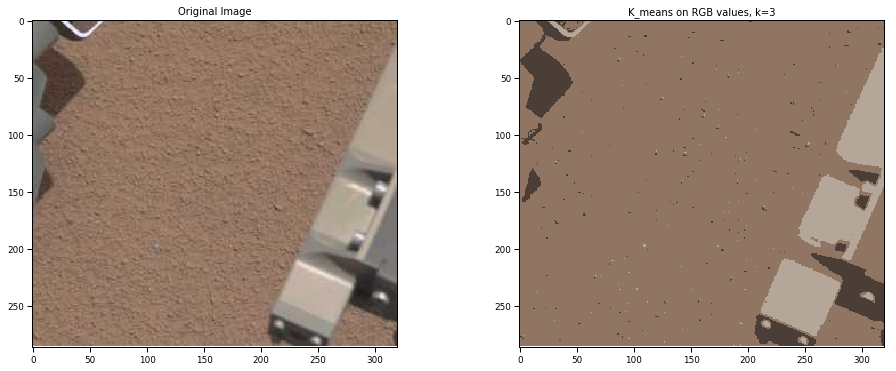

In [82]:
##### KMeans on RGB Values #####

data = Int / 255.0
dims=Int.shape
data=data.reshape(dims[0]*dims[1],3)

kmeans = KMeans(3)
kmeans.fit(data)
col_RGB = kmeans.cluster_centers_[kmeans.predict(data)]
col_RGB = col_RGB.reshape(dims)

###### Plot comparison #####

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].imshow(Int)
ax[0].set_title('Original Image', size=10)
ax[1].imshow(col_RGB)
ax[1].set_title('K_means on RGB values, k=3', size=10)

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

/Users/chalvidalm/anaconda2/lib/python2.7/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Users/chalvidalm/anaconda2/lib/python2.7/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


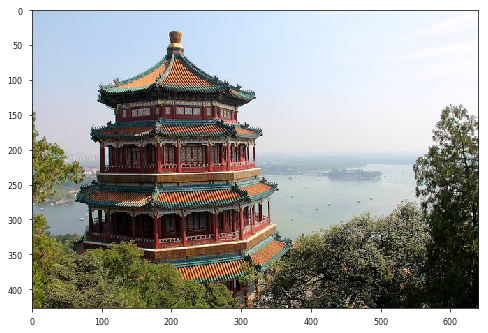

In [8]:
import PIL
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')
fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

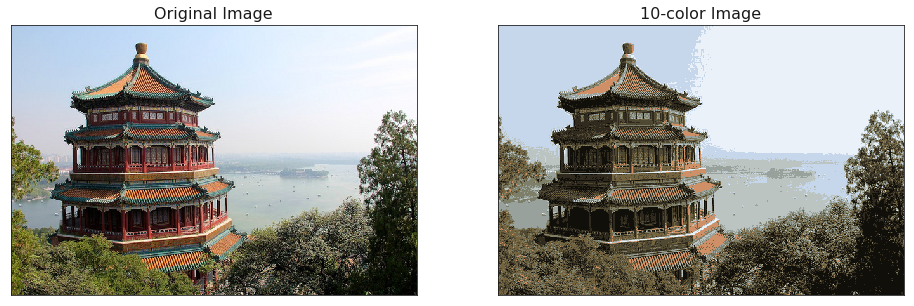

In [12]:
##### Data scaling and reshaping #####
dims = china.shape
data = china / 255.0 # normalising data for clustering purpose
data = data.reshape(china.shape[0]*china.shape[1], 3)

##### Performing kMeans on picture #####

kmeans = KMeans(10)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

china_recolored = new_colors.reshape(china.shape)

##### Ploting compressed image #####

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))

ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('10-color Image', size=16);